In [51]:
from segcarson import get_segmentation
from utils.io import convert_mhd_to_nifti
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from models import deep_strain_model
from datasets import base_dataset
from datasets.nifti_dataset import resample_nifti
from tensorflow.keras.optimizers import Adam
from scipy.ndimage.measurements import center_of_mass
from datasets.base_dataset import roll_and_pad_256x256_to_center_inv
from datasets.base_dataset import _roll2center_crop
from scipy.ndimage import gaussian_filter
import numpy as np
import SimpleITK as sitk
from utils.strain_from_motion_prueba import *
from utils.utils_aha import *
import constant

rv_pt = [89,184,9]

########################## Mask and normalization ######################################


def normalize(x, axis=(0, 1, 2)):
    # normalize per volume (x,y,z) frame
    mu = x.mean(axis=axis, keepdims=True)
    sd = x.std(axis=axis, keepdims=True)
    return (x - mu) / (sd + 1e-8)


def get_mask(V, netS):
    nx, ny, nz, nt = V.shape

    M = np.zeros((nx, ny, nz, nt))
    v = V.transpose((2, 3, 0, 1)).reshape((-1, nx, ny))  # (nz*nt,nx,ny)
    v = normalize(v)
    for t in range(nt):
        for z in range(nz):
            m = netS(
                v[z * nt + t, nx // 2 - 64 : nx // 2 + 64, ny // 2 - 64 : ny // 2 + 64][
                    None, ..., None
                ]
            )
            M[nx // 2 - 64 : nx // 2 + 64, ny // 2 - 64 : ny // 2 + 64, z, t] += (
                np.argmax(m, -1).transpose((1, 2, 0)).reshape((128, 128))
            )
    return M


######################### Constants and arguments ######################################

class CarMEN_options:
    def __init__(self):
        self.isTrain = False
        self.volume_shape = (128, 128, 16, 1)
        self.pretrained_models_netS = "models/carson_Jan2021.h5"
        self.pretrained_models_netME = "models/carmen_Jan2021.h5"


#########################     Motion and Strain   ######################################

patient = 'v9'
data_folder = os.path.join(os.getcwd(),'MHD_Data',patient,'cSAX')

print("Cargo volumen")
####### TRANSFORMO MHD EN NIFTI
convert_mhd_to_nifti(data_folder, patient, data_folder)
# Me lo tira en x,y,z
cine = nib.load(os.path.join(data_folder, f"{patient}.nii.gz"))

print("Segmento")
####### SEGMENTACION
#myo = nib.nifti1.Nifti1Image(get_segmentation(data_folder, patient), cine.affine)
myo = get_segmentation(cine)

print("Deformacion")
####### MOVIMIENTO Y STRAIN
opt = CarMEN_options()
model = deep_strain_model.DeepStrain(Adam, opt=opt)
netME = model.get_netME()

print("Motion and strain on patient.")

V_nifti = cine
M_nifti = myo

print('Non resampled shape: ', V_nifti.shape)

V_nifti_resampled = resample_nifti(
    V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16
)
M_nifti_resampled = resample_nifti(
    M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16
)

print('Resampled volume shape: ', V_nifti_resampled.shape)

center = center_of_mass(M_nifti_resampled.get_fdata()[:, :, :, 0] == 2)
V = V_nifti_resampled.get_fdata()
M = M_nifti_resampled.get_fdata()

rv_pt = center_of_mass(M[:, :, :, 0] == 1)

V = _roll2center_crop(x=V, center=center)
M_centered = _roll2center_crop(x=M, center=center)

I = np.argmax((M == 1).sum(axis=(0, 1, 3)))
if I > M.shape[2] // 2:
    print("flip")
    V = V[:, :, ::-1]
    M = M[:, :, ::-1]

V = normalize(V, axis=(0, 1, 2))

mask = M.transpose((3,2,1,0))
mask = mask==2
mask = mask.astype(float)

myo = sitk.GetImageFromArray(mask[0,:,:,:])
coord_i, data_i = lv_local_coord_system(myo, 0, True)
aha_img = create_aha(myo, rv_pt, 0, True)

Icoord_i = sitk.GetArrayFromImage(coord_i)
seg_aha = sitk.GetArrayFromImage(aha_img)

#  # coord --> (dim, 9): # 3x3 = [c_l,c_c,c_r]
Icoord_i = Icoord_i.reshape(Icoord_i.shape[:3]+(3,3))
ldir = Icoord_i[...,0]
cdir = Icoord_i[...,1]
rdir = Icoord_i[...,2]
Icoord = [ldir, cdir, rdir]

dfield = []

iec_aha = np.zeros((16, constant.nframes))
ier_aha = np.zeros((16, constant.nframes))
ierc_aha = np.zeros((16, constant.nframes))
iel_aha = np.zeros((16, constant.nframes))

iec, ier, ierc, ec, er, erc, Ec, Er, Erc, iel, el, El = ([None]*constant.nframes, [None]*constant.nframes, [None]*constant.nframes, 
                                                        [None]*constant.nframes, [None]*constant.nframes, [None]*constant.nframes, 
                                                        [None]*constant.nframes, [None]*constant.nframes, [None]*constant.nframes,
                                                        [None]*constant.nframes, [None]*constant.nframes, [None]*constant.nframes)

iecm, ierm, iercm, ecm, erm, ercm, Ecm, Erm, Ercm, ielm, elm, Elm = ([None]*constant.nframes, [None]*constant.nframes, [None]*constant.nframes, 
                                                        [None]*constant.nframes, [None]*constant.nframes, [None]*constant.nframes, 
                                                        [None]*constant.nframes, [None]*constant.nframes, [None]*constant.nframes,
                                                        [None]*constant.nframes, [None]*constant.nframes, [None]*constant.nframes)

label = 1
strain = np.zeros((constant.nframes, 3))

for t in range(constant.nframes):
    V_0 = V[..., 0][None, ..., None]
    V_t = V[..., t][None, ..., None]
    df = gaussian_filter(netME([V_0, V_t]).numpy(), sigma=(0,2,2,2.5/8,0)).squeeze()

    if t == 10:
        dfplot = df.squeeze()
        v0plot = V_0.squeeze()
        vtplot = V_t.squeeze()

    nifti_info = {'center_resampled' : center,
                'center_resampled_256x256' : (128,128),
                'shape_resampled' : (256,256,16)}
    df = roll_and_pad_256x256_to_center_inv(df, nifti_info)
    df = df.transpose((3,2,1,0))
    dfield.append(df)
    mk = mask[0,:,:,:]

    (iec[t], ier[t], ierc[t], ec[t], er[t], erc[t],
    Ec[t], Er[t], Erc[t], iel[t], el[t], El[t]) = cine_dense_strain3D(df=df, Icoord=Icoord, mask=mk, ba_channel=0)
    (iecm[t], ierm[t], iercm[t], ecm[t], erm[t], ercm[t],
    Ecm[t], Erm[t], Ercm[t], ielm[t], elm[t], Elm[t]) = (iec[t][mk==label].mean(), ier[t][mk==label].mean(), ierc[t][mk==label].mean(), 
                                                    ec[t][mk==label].mean(),er[t][mk==label].mean(), erc[t][mk==label].mean(),
                                                    Ec[t][mk==label].mean(), Er[t][mk==label].mean(), Erc[t][mk==label].mean(),
                                                    iel[t][mk==label].mean(), el[t][mk==label].mean(), El[t][mk==label].mean())
    strain[t, 0] = ierm[t]
    strain[t, 1] = iecm[t]
    strain[t, 2] = ielm[t]

    for j in range(16):
        rr,cc,jj = np.where(seg_aha == j+1)

        # rho is  1.05 g/cm^3 = 1.05*1e-3 g/mm^3
        #  vol_aha[j, i] = rr.size * rho
        iec_aha[j, t] = iec[t][rr,cc,jj].mean() * 100
        ier_aha[j, t] = ier[t][rr,cc,jj].mean() * 100
        ierc_aha[j, t] = ierc[t][rr,cc,jj].mean() * 100
        iel_aha[j, t] = iel[t][rr,cc,jj].mean() * 100

plt.figure()
plt.title('SEG LUCCA Y CAMPO DEEP')
plt.plot(100*strain[:,1], color='c', label="C", marker='.')
plt.legend()
plt.figure()
plt.title('SEG LUCCA Y CAMPO DEEP')
plt.plot(100*strain[:,0], color='r', label="R", marker='.')
plt.legend()
plt.figure()
plt.title('SEG LUCCA Y CAMPO DEEP')
plt.plot(100*strain[:,2], color='g', label="L", marker='.')
plt.legend()
plt.show()


/var/folders/39/9622jvw14cxg_gy0jc2cxn_80000gn/T/ipykernel_59393/3410380755.py:12: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass


Cargo volumen
/Users/yhibo/tensorflow-test/PIStrain/script/MHD_Data/v9/cSAX/v9.nii.gz
Segmento


TypeError: get_segmentation() takes 1 positional argument but 2 were given

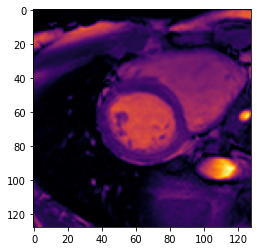

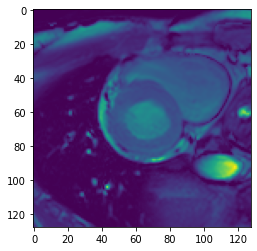

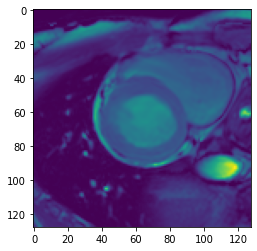

In [16]:
plt.imshow(v0plot[:,:,5], cmap='inferno')
plt.figure()
plt.imshow(vtplot[:,:,5])

from models.dense_image_warp import dense_image_warp3d as warp

v0_pred = warp(vtplot[None,...,None], dfplot[None,...])
v0_pred = v0_pred.numpy().squeeze()

plt.figure()
plt.imshow(v0_pred[:,:,5])

(1, 5, 128, 128, 16)
(128, 128, 16) (128, 128, 16) (128, 128, 16) (128, 128, 16) (128, 128, 16) (1, 128, 128, 16, 3)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.34807795], dtype=float32)>

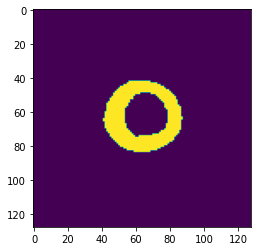

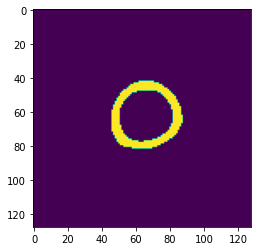

In [49]:

import tensorflow as tf
from models.networkss import *
from tensorflow.keras import backend as K

def criterion_netME(y_true, y_pred):

    u = y_pred
    V_0 = tf.expand_dims(y_true[:,0], axis=-1)
    V_t = tf.expand_dims(y_true[:,1], axis=-1)
    M_0 = tf.expand_dims(y_true[:,2], axis=-1)
    M_t = tf.expand_dims(y_true[:,3], axis=-1)
    res = tf.expand_dims(y_true[:,4], axis=-1)

    V_0_pred = warp(V_t, u)

    M_t_split = tf.split(M_t, M_t.shape[-1], -1)
    M_0_pred  = tf.round(K.concatenate([warp(K.cast(mt, K.dtype(V_t)), u) for mt in M_t_split], -1))

    plt.imshow(M_0_pred.numpy()[0,:,:,5,0]==2)
    plt.figure()
    plt.imshow(M_0.numpy()[0,:,:,5,0]==2)
    # M_0_pred  = keras.activations.softmax(M_0_pred)

    # plt.imshow(M_0_pred.numpy()[0,:,:,5,0])

    lambda_i = np.array(0.01, dtype= np.float32)
    lambda_a = np.array(0.5, dtype= np.float32)
    lambda_s = np.array(0.1, dtype= np.float32)

    dice = Dice()
    grad = Grad()

    # Intensity loss
    
    L_i = K.mean(K.abs(V_0_pred - V_0), axis=(1,2,3,4))

    # Anatomical loss
    L_a = 0
    L_a += dice.loss(K.cast(M_0==0, dtype=tf.float32), K.cast(M_0_pred==0, dtype=tf.float32))
    L_a += dice.loss(K.cast(M_0==1, dtype=tf.float32), K.cast(M_0_pred==1, dtype=tf.float32))
    L_a += dice.loss(K.cast(M_0==2, dtype=tf.float32), K.cast(M_0_pred==2, dtype=tf.float32))
    L_a += dice.loss(K.cast(M_0==3, dtype=tf.float32), K.cast(M_0_pred==3, dtype=tf.float32))
    L_a = L_a/4.0

    # Smoothness loss
    resux = tf.ones(tf.shape(u)[:-1], dtype=tf.float32)
    resuy = tf.ones(tf.shape(u)[:-1], dtype=tf.float32)
    resuz = tf.ones(tf.shape(u)[:-1], dtype=tf.float32)
    resu = tf.stack([resux, resuy, resuz], axis=-1)
    resu = u*resu
    L_s = grad.loss([],K.cast(resu,dtype=tf.float32))

    return lambda_i * L_i + lambda_a * L_a + lambda_s * L_s

v0 = v0plot.astype(np.float32)
vt = vtplot.astype(np.float32)
m0 = M_centered[...,0].astype(np.float32)
mt = M_centered[...,10].astype(np.float32)
res = np.ones_like(v0).astype(np.float32)
u = dfplot[None,...].astype(np.float32)
y_true = np.array([v0, vt, m0, mt, res])[None,...]
#print shapesx
print(y_true.shape)
print(v0.shape, vt.shape, m0.shape, mt.shape, res.shape, u.shape)

criterion_netME(y_true, u)

NameError: name 'iec_aha' is not defined

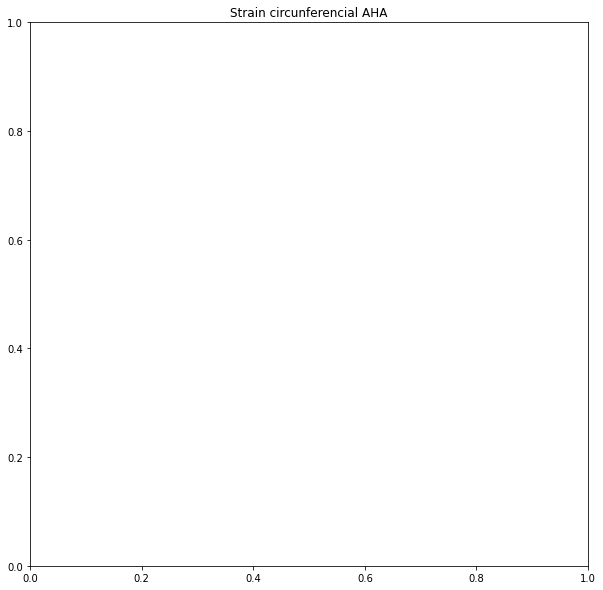

In [3]:
plt.figure(figsize=(10,10))
plt.title('Strain circunferencial AHA')
for i in range(16):
    plt.plot(iec_aha[i], label=f"Segmento {i+1}", marker='.')
plt.legend()

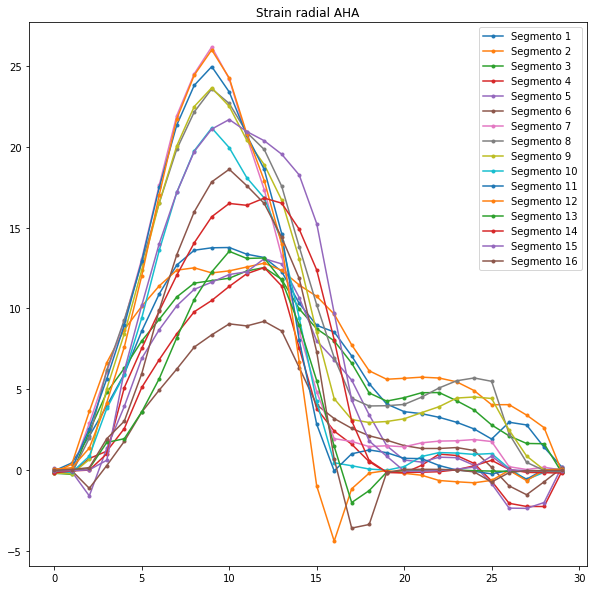

In [39]:
plt.figure(figsize=(10,10))
plt.title('Strain radial AHA')
for i in range(16):
    plt.plot(ier_aha[i], label=f"Segmento {i+1}", marker='.')
plt.legend()

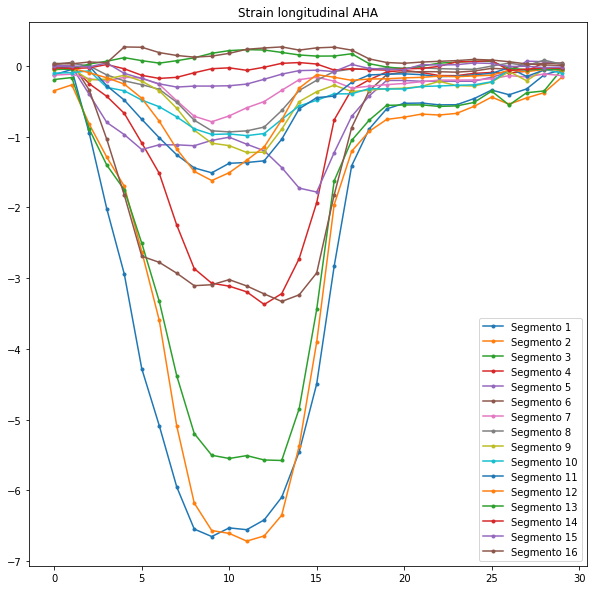

In [40]:
plt.figure(figsize=(10,10))
plt.title('Strain longitudinal AHA')
for i in range(16):
    plt.plot(iel_aha[i], label=f"Segmento {i+1}", marker='.')
plt.legend()

In [1]:
import numpy as np
strainaha = np.load('results/strain/our_seg/v9_strain_aha.npy')

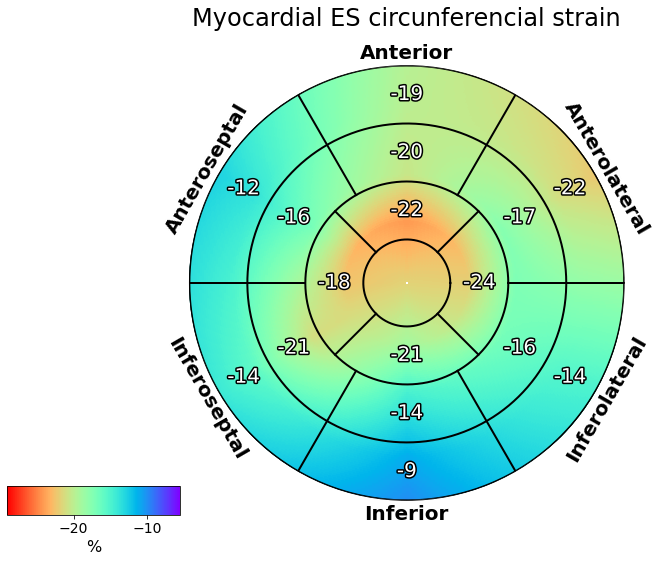

In [9]:
from SmoothAHAplot.smoothahaplot import AHAPlotting
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import pandas as pd


exp_strain_data = np.concatenate((strainaha[0, :, 10], np.array((strainaha[0, -4:, 11].mean(),))))
exp_mw_data = [1926, 1525, 1673, 2048, 2325, 2200, 2197, 2014, 1982, 2199, 2431, 2409, 2554, 2961, 2328, 2329, 2288]
n_seg = 17
echop = False
segments_17 = ['Basal Anterior', 'Basal Anteroseptal', 'Basal Inferoseptal',
               'Basal Inferior', 'Basal Inferolateral', 'Basal Anterolateral',
               'Mid Anterior', 'Mid Anteroseptal', 'Mid Inferoseptal',
               'Mid Inferior', 'Mid Inferolateral', 'Mid Anterolateral',
               'Apical Anterior', 'Apical Septal', 'Apical Inferior', 'Apical Lateral', 'Apex']

strain_dict = {k: v for (k, v) in zip(segments_17, exp_strain_data)}
mw_dict = {k: v for (k, v) in zip(segments_17, exp_mw_data)}

aha = AHAPlotting(values=exp_strain_data, plot_output_path='./images')
cmap = plt.get_cmap('rainbow_r')
norm = (strainaha[0, :, 11].min()-5, strainaha[0, :, 11].max()+5)
aha.bullseye_17_smooth(cmap=cmap, norm=norm, title='Myocardial ES circunferencial strain', units='%', smooth_contour=False)

# levels = MaxNLocator(nbins=12).tick_values(-30, 30)
# cmap = plt.get_cmap('seismic_r')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# aha.bullseye_17_smooth(cmap=cmap, norm=norm, units='%', smooth_contour=True)
plt.show()

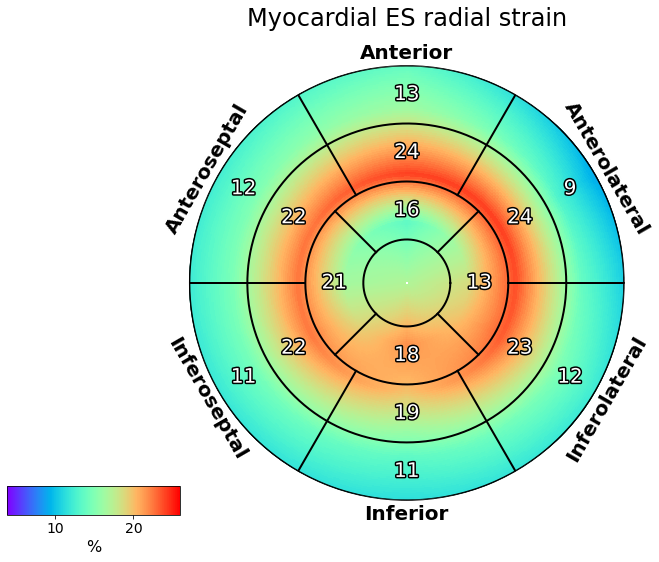

In [12]:
from SmoothAHAplot.smoothahaplot import AHAPlotting
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import pandas as pd


exp_strain_data = np.concatenate((strainaha[1, :, 10], np.array((strainaha[1, -4:, 11].mean(),))))
exp_mw_data = [1926, 1525, 1673, 2048, 2325, 2200, 2197, 2014, 1982, 2199, 2431, 2409, 2554, 2961, 2328, 2329, 2288]
n_seg = 17
echop = False
segments_17 = ['Basal Anterior', 'Basal Anteroseptal', 'Basal Inferoseptal',
               'Basal Inferior', 'Basal Inferolateral', 'Basal Anterolateral',
               'Mid Anterior', 'Mid Anteroseptal', 'Mid Inferoseptal',
               'Mid Inferior', 'Mid Inferolateral', 'Mid Anterolateral',
               'Apical Anterior', 'Apical Septal', 'Apical Inferior', 'Apical Lateral', 'Apex']

strain_dict = {k: v for (k, v) in zip(segments_17, exp_strain_data)}
mw_dict = {k: v for (k, v) in zip(segments_17, exp_mw_data)}

aha = AHAPlotting(values=exp_strain_data, plot_output_path='./images')
cmap = plt.get_cmap('rainbow')
norm = (strainaha[1, :, 11].min()-5, strainaha[1, :, 11].max()+5)
aha.bullseye_17_smooth(cmap=cmap, norm=norm, title='Myocardial ES radial strain', units='%', smooth_contour=False)

# levels = MaxNLocator(nbins=12).tick_values(-30, 30)
# cmap = plt.get_cmap('seismic_r')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# aha.bullseye_17_smooth(cmap=cmap, norm=norm, units='%', smooth_contour=True)
plt.show()

In [61]:
from matplotlib import colors
transparente = [0,0,0,0]
blue = [44,145,191,1]
aqua = [84,193,196,1]
green = [176,216,154,1]
forestgreen = [72,122,71,1]
lavander = [199,152,205,1]
eggplant = [95,46,88,1]
rose = [224,158,172,1]
coral = [241,112,40,1]
red = [200,41,48,1]
orange = [241,85,38,1]
chocolate = [100,68,62,1]
butter = [255,245,160,1]
mustard = [231,192,52,1]
tan = [223,209,0,1]
softgray = [20,20,20,1]
black = [0,0,0,1]


cmap = colors.ListedColormap([transparente, blue, aqua, green, forestgreen, lavander, eggplant, rose, coral, red, orange, chocolate, butter, mustard, tan, softgray, black][0:17])

bounds=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
norm = colors.BoundaryNorm(bounds,17)

148.88518072289156

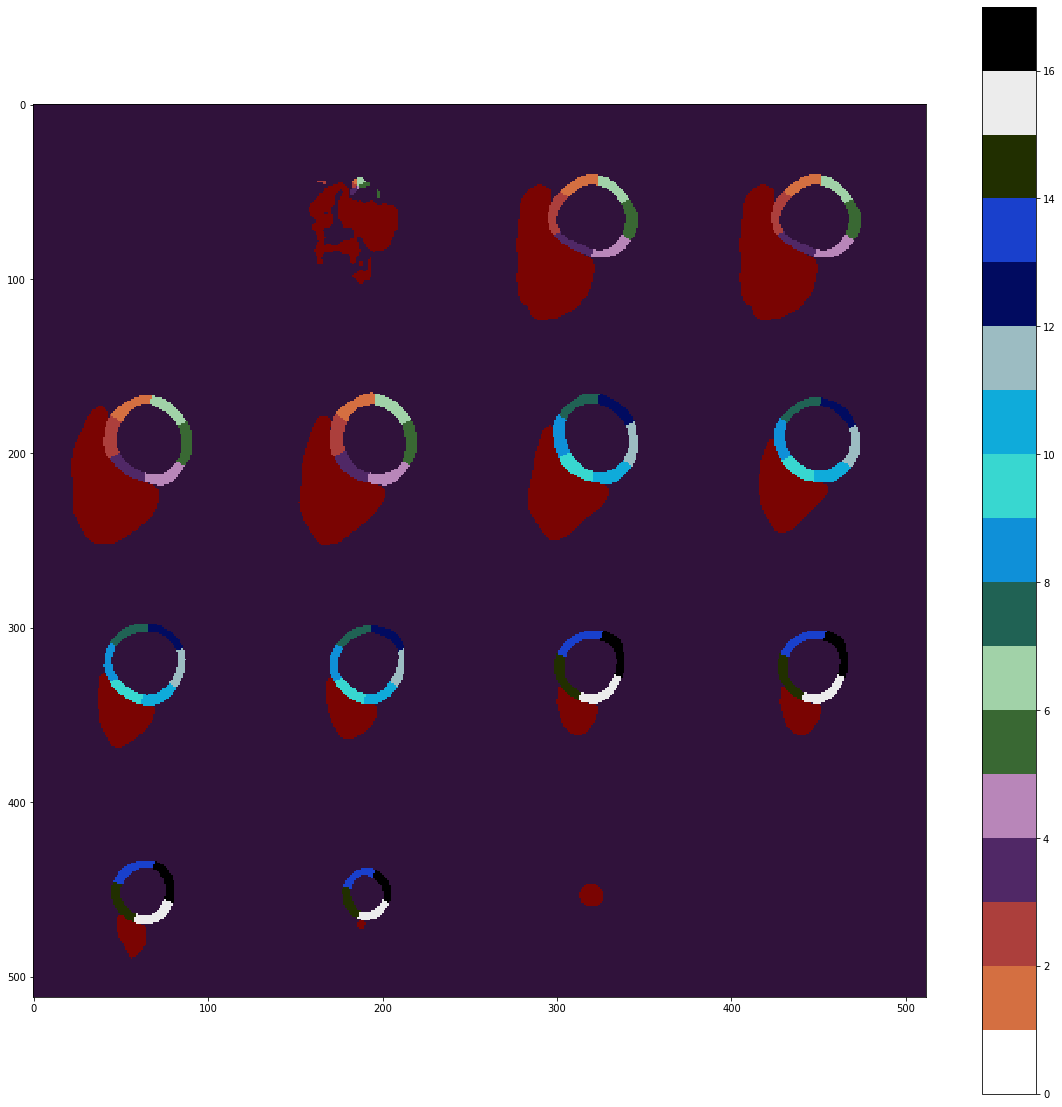

In [84]:
from skimage.util import montage
plt.figure(figsize=(20,20))
seg_0 = sitk.GetArrayFromImage(myo)
img = np.zeros(seg_0[9].shape)
img[184,89] = 1
plt.imshow(montage(M.transpose((3,2,1,0))[0][:,int(center[1]-64):int(center[1]+64),int(center[0]-64):int(center[0]+64)]==1), cmap='turbo', interpolation="nearest")
#plt.imshow(mask[0][2], cmap="inferno")
plt.imshow(montage(seg_aha[:,int(center[1]-64):int(center[1]+64),int(center[0]-64):int(center[0]+64)]), cmap=cmap, norm=norm, interpolation="nearest")
#plt.imshow(2*np.ones(seg_0[10].shape), cmap=cmap, norm=norm)
plt.colorbar()
center_of_mass(M.transpose((3,2,1,0))[0]==1)
center[1]

In [69]:
seg_aha[:,0:5,:]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..

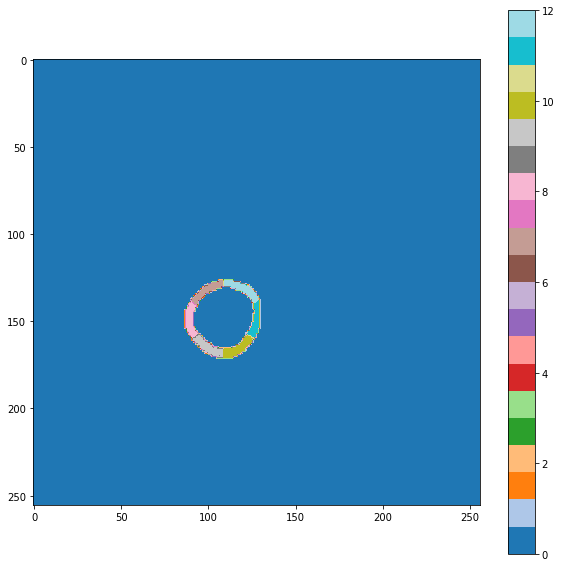

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(seg_aha[9], cmap="tab20")
plt.colorbar()

In [87]:
from matplotlib import colors
transparente = [0,0,0,0]
blue = [44,145,191,1]
aqua = [84,193,196,1]
green = [176,216,154,1]
forestgreen = [72,122,71,1]
lavander = [199,152,205,1]
eggplant = [95,46,88,1]
rose = [224,158,172,1]
coral = [241,112,40,1]
red = [200,41,48,1]
orange = [241,85,38,1]
chocolate = [100,68,62,1]
butter = [255,245,160,1]
mustard = [231,192,52,1]
tan = [223,209,180,1]
softgray = [200,200,200,1]
black = [0,0,0,1]


cmap = colors.ListedColormap([transparente, blue, aqua, green, forestgreen, lavander, eggplant, rose, coral, red, orange, chocolate, butter, mustard, tan, softgray, black])

bounds=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
norm = colors.BoundaryNorm(bounds, cmap.N)

/var/folders/39/9622jvw14cxg_gy0jc2cxn_80000gn/T/ipykernel_34675/2004127578.py:72: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm, shading='auto')


[0.         0.33333333]
[[0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 [0.         0.33333333]
 

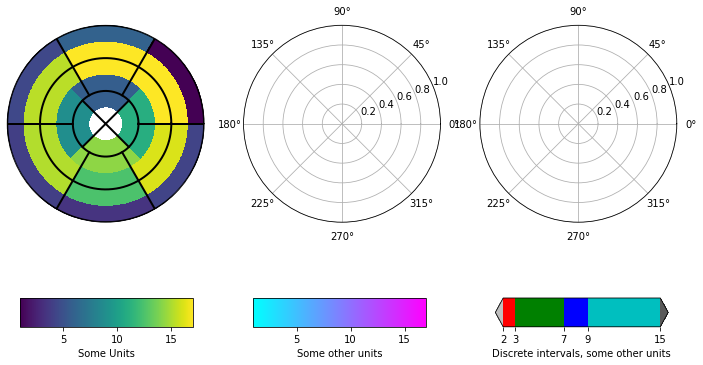

In [54]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


def bullseye_plot(ax, data, seg_bold=None, cmap=None, norm=None):
    """
    Bullseye representation for the left ventricle.

    Parameters
    ----------
    ax : axes
    data : list of int and float
        The intensity values for each of the 17 segments
    seg_bold : list of int, optional
        A list with the segments to highlight
    cmap : ColorMap or None, optional
        Optional argument to set the desired colormap
    norm : Normalize or None, optional
        Optional argument to normalize data into the [0.0, 1.0] range

    Notes
    -----
    This function creates the 17 segment model for the left ventricle according
    to the American Heart Association (AHA) [1]_

    References
    ----------
    .. [1] M. D. Cerqueira, N. J. Weissman, V. Dilsizian, A. K. Jacobs,
        S. Kaul, W. K. Laskey, D. J. Pennell, J. A. Rumberger, T. Ryan,
        and M. S. Verani, "Standardized myocardial segmentation and
        nomenclature for tomographic imaging of the heart",
        Circulation, vol. 105, no. 4, pp. 539-542, 2002.
    """
    if seg_bold is None:
        seg_bold = []

    linewidth = 2
    data = np.ravel(data)

    if cmap is None:
        cmap = plt.cm.viridis

    if norm is None:
        norm = mpl.colors.Normalize(vmin=data.min(), vmax=data.max())

    theta = np.linspace(0, 2 * np.pi, 768)
    r = np.linspace(0, 1, 4)

    # Create the bound for the segment 17
    for i in range(r.shape[0]):
        ax.plot(theta, np.repeat(r[i], theta.shape), '-k', lw=linewidth)

    # Create the bounds for the segments 1-12
    for i in range(6):
        theta_i = np.deg2rad(i * 60)
        ax.plot([theta_i, theta_i], [r[1], 1], '-k', lw=linewidth)

    # Create the bounds for the segments 13-16
    for i in range(4):
        theta_i = np.deg2rad(i * 90 - 45)
        ax.plot([theta_i, theta_i], [r[0], r[1]], '-k', lw=linewidth)

    # Fill the segments 1-6
    r0 = r[2:4]
    r0 = np.repeat(r0[:, np.newaxis], 128, axis=1).T
    for i in range(6):
        # First segment start at 60 degrees
        theta0 = theta[i * 128:i * 128 + 128] + np.deg2rad(60)
        theta0 = np.repeat(theta0[:, np.newaxis], 2, axis=1)
        z = np.ones((128, 2)) * data[i]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm, shading='auto')
        if i + 1 in seg_bold:
            ax.plot(theta0, r0, '-k', lw=linewidth + 2)
            ax.plot(theta0[0], [r[2], r[3]], '-k', lw=linewidth + 1)
            ax.plot(theta0[-1], [r[2], r[3]], '-k', lw=linewidth + 1)

    # Fill the segments 7-12
    r0 = r[1:3]
    r0 = np.repeat(r0[:, np.newaxis], 128, axis=1).T
    for i in range(6):
        # First segment start at 60 degrees
        theta0 = theta[i * 128:i * 128 + 128] + np.deg2rad(60)
        theta0 = np.repeat(theta0[:, np.newaxis], 2, axis=1)
        z = np.ones((128, 2)) * data[i + 6]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm, shading='auto')
        if i + 7 in seg_bold:
            ax.plot(theta0, r0, '-k', lw=linewidth + 2)
            ax.plot(theta0[0], [r[1], r[2]], '-k', lw=linewidth + 1)
            ax.plot(theta0[-1], [r[1], r[2]], '-k', lw=linewidth + 1)

    # Fill the segments 13-16
    r0 = r[0:2]
    print(r0)
    r0 = np.repeat(r0[:, np.newaxis], 192, axis=1).T
    print(r0)
    for i in range(4):
        # First segment start at 45 degrees
        theta0 = theta[i * 192:i * 192 + 192] + np.deg2rad(45)
        theta0 = np.repeat(theta0[:, np.newaxis], 2, axis=1)
        z = np.ones((192, 2)) * data[i + 12]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm, shading='auto')
        if i + 13 in seg_bold:
            ax.plot(theta0, r0, '-k', lw=linewidth + 2)
            ax.plot(theta0[0], [r[0], r[1]], '-k', lw=linewidth + 1)
            ax.plot(theta0[-1], [r[0], r[1]], '-k', lw=linewidth + 1)

    # Fill the segments 17
    if data.size == 17:
        r0 = np.array([0, r[0]])
        r0 = np.repeat(r0[:, np.newaxis], theta.size, axis=1).T
        theta0 = np.repeat(theta[:, np.newaxis], 2, axis=1)
        z = np.ones((theta.size, 2)) * data[16]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm, shading='auto')
        if 17 in seg_bold:
            ax.plot(theta0, r0, '-k', lw=linewidth + 2)

    ax.set_ylim([0, 1])
    ax.set_yticklabels([])
    ax.set_xticklabels([])


# Create the fake data
data = np.arange(17) + 1


# Make a figure and axes with dimensions as desired.
fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=3,
                       subplot_kw=dict(projection='polar'))
fig.canvas.manager.set_window_title('Left Ventricle Bulls Eyes (AHA)')

# Create the axis for the colorbars
axl = fig.add_axes([0.14, 0.15, 0.2, 0.05])
axl2 = fig.add_axes([0.41, 0.15, 0.2, 0.05])
axl3 = fig.add_axes([0.69, 0.15, 0.2, 0.05])


# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=1, vmax=17)
# Create an empty ScalarMappable to set the colorbar's colormap and norm.
# The following gives a basic continuous colorbar with ticks and labels.
fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
             cax=axl, orientation='horizontal', label='Some Units')


# And again for the second colorbar.
cmap2 = mpl.cm.cool
norm2 = mpl.colors.Normalize(vmin=1, vmax=17)
fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap2, norm=norm2),
             cax=axl2, orientation='horizontal', label='Some other units')


# The second example illustrates the use of a ListedColormap, a
# BoundaryNorm, and extended ends to show the "over" and "under"
# value colors.
cmap3 = (mpl.colors.ListedColormap(['r', 'g', 'b', 'c'])
         .with_extremes(over='0.35', under='0.75'))
# If a ListedColormap is used, the length of the bounds array must be
# one greater than the length of the color list.  The bounds must be
# monotonically increasing.
bounds = [2, 3, 7, 9, 15]
norm3 = mpl.colors.BoundaryNorm(bounds, cmap3.N)
fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap3, norm=norm3),
             cax=axl3,
             # to use 'extend', you must specify two extra boundaries:
             boundaries=[0] + bounds + [18],
             extend='both',
             ticks=bounds,  # optional
             spacing='proportional',
             orientation='horizontal',
             label='Discrete intervals, some other units')


# Create the 17 segment model
bullseye_plot(ax[0], ier_aha[:,10])

plt.show()

In [52]:
r = np.linspace(0, 1, 4)
r

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [55]:
ier_aha[:,10].size

16

In [18]:
from cgi import print_arguments
import SimpleITK as sitk
patient = 'v16'
img = sitk.ReadImage(f'MHD_Data/{patient}/cSAX/{patient}_cSAX_time_1.mhd')
print(img.GetSize())
print(img.GetSpacing())

(256, 256, 14)
(1.25, 1.25, 8.079284819380607)


In [1]:
from models import deep_strain_model
from datasets import base_dataset
from datasets.nifti_dataset import resample_nifti
from tensorflow.keras.optimizers import Adam
from scipy.ndimage.measurements import center_of_mass
from datasets.base_dataset import roll_and_pad_256x256_to_center_inv
from datasets.base_dataset import _roll2center_crop
from scipy.ndimage import gaussian_filter
import numpy as np
import SimpleITK as sitk
from utils.strain_from_motion import *
from utils.utils_aha import *
import constant

##########################      Normalization     ######################################


def normalize(x, axis=(0, 1, 2)):
    # normalize per volume (x,y,z) frame
    mu = x.mean(axis=axis, keepdims=True)
    sd = x.std(axis=axis, keepdims=True)
    return (x - mu) / (sd + 1e-8)

######################### Constants and arguments ######################################

class CarMEN_options:
    def __init__(self):
        self.isTrain = False
        self.volume_shape = (128, 128, 16, 1)
        self.pretrained_models_netS = "models/carson_Jan2021.h5"
        self.pretrained_models_netME = "models/carmen_Jan2021.h5"


/var/folders/39/9622jvw14cxg_gy0jc2cxn_80000gn/T/ipykernel_59521/1674685631.py:5: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass


In [2]:
opt = CarMEN_options()
model = deep_strain_model.DeepStrain(Adam, opt=opt)
netME = model.get_netME()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(netME, to_file='netME.png', show_shapes=True)

In [16]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

M = nib.load("results/images/volume/v1.nii.gz")
M.affine[0]

array([  -1.25      ,    0.        ,    0.        , -111.80957794])

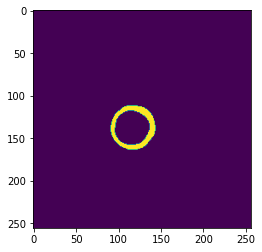

In [9]:
plt.imshow(M.get_fdata()[:,:,6])

In [3]:
netME.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 16 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128, 128, 16 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 128, 128, 16, 0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv3d_40 (Conv3D)              (None, 128, 128, 16, 1216        concatenate_7[0][0]        

: 

In [50]:
from seglucca import get_segmentation
from utils.io import convert_mhd_to_nifti
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from models import deep_strain_model
from datasets import base_dataset
from datasets.nifti_dataset import resample_nifti
from tensorflow.keras.optimizers import Adam
from scipy.ndimage.measurements import center_of_mass
from datasets.base_dataset import roll_and_pad_256x256_to_center_inv
from datasets.base_dataset import _roll2center_crop
from scipy.ndimage import gaussian_filter
import numpy as np
import SimpleITK as sitk
from utils.strain_from_motion_prueba import *
from utils.utils_aha import *

########################## Mask and normalization ######################################


def normalize(x, axis=(0, 1, 2)):
    # normalize per volume (x,y,z) frame
    mu = x.mean(axis=axis, keepdims=True)
    sd = x.std(axis=axis, keepdims=True)
    return (x - mu) / (sd + 1e-8)


def get_mask(V, netS):
    nx, ny, nz, nt = V.shape

    M = np.zeros((nx, ny, nz, nt))
    v = V.transpose((2, 3, 0, 1)).reshape((-1, nx, ny))  # (nz*nt,nx,ny)
    v = normalize(v)
    for t in range(nt):
        for z in range(nz):
            m = netS(
                v[z * nt + t, nx // 2 - 64 : nx // 2 + 64, ny // 2 - 64 : ny // 2 + 64][
                    None, ..., None
                ]
            )
            M[nx // 2 - 64 : nx // 2 + 64, ny // 2 - 64 : ny // 2 + 64, z, t] += (
                np.argmax(m, -1).transpose((1, 2, 0)).reshape((128, 128))
            )
    return M


######################### Constants and arguments ######################################

class CarMEN_options:
    def __init__(self):
        self.isTrain = False
        self.volume_shape = (128, 128, 16, 1)
        self.pretrained_models_netS = "models/carson_Jan2021.h5"
        self.pretrained_models_netME = "models/carmen_Jan2021.h5"


#########################     Motion and Strain   ######################################

patient = 'patient001'
data_folder = '.'

print("Cargo volumen")
cine = nib.load(patient + '_4d.nii.gz')

print("Segmento")
####### SEGMENTACION
myo = nib.nifti1.Nifti1Image(get_segmentation(data_folder, patient), cine.affine)

print("Deformacion")
####### MOVIMIENTO Y STRAIN
opt = CarMEN_options()
model = deep_strain_model.DeepStrain(Adam, opt=opt)
netME = model.get_netME()

print("Motion and strain on patient.")

V_nifti = cine
M_nifti = myo

print('Non resampled shape: ', V_nifti.shape)

V_nifti_resampled = resample_nifti(
    V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16
)
M_nifti_resampled = resample_nifti(
    M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16
)

print('Resampled volume shape: ', V_nifti_resampled.shape)

center = center_of_mass(M_nifti_resampled.get_fdata()[:, :, :, 0] == 2)
V = V_nifti_resampled.get_fdata()
M = M_nifti_resampled.get_fdata()
nframes = V.shape[-1]

rv_pt = center_of_mass(M[:, :, :, 0] == 1)

V = _roll2center_crop(x=V, center=center)
M_centered = _roll2center_crop(x=M, center=center)

I = np.argmax((M == 1).sum(axis=(0, 1, 3)))
if I > M.shape[2] // 2:
    print("flip")
    V = V[:, :, ::-1]
    M = M[:, :, ::-1]

V = normalize(V, axis=(0, 1, 2))

mask = M.transpose((3,2,1,0))
mask = mask==2
mask = mask.astype(float)

myo = sitk.GetImageFromArray(mask[0,:,:,:])
coord_i, data_i = lv_local_coord_system(myo, 0, True)
aha_img = create_aha(myo, rv_pt, 0, True)

Icoord_i = sitk.GetArrayFromImage(coord_i)
seg_aha = sitk.GetArrayFromImage(aha_img)

#  # coord --> (dim, 9): # 3x3 = [c_l,c_c,c_r]
Icoord_i = Icoord_i.reshape(Icoord_i.shape[:3]+(3,3))
ldir = Icoord_i[...,0]
cdir = Icoord_i[...,1]
rdir = Icoord_i[...,2]
Icoord = [ldir, cdir, rdir]

dfield = []

iec_aha = np.zeros((16, nframes))
ier_aha = np.zeros((16, nframes))
ierc_aha = np.zeros((16, nframes))
iel_aha = np.zeros((16, nframes))

iec, ier, ierc, ec, er, erc, Ec, Er, Erc, iel, el, El = ([None]*nframes, [None]*nframes, [None]*nframes, 
                                                        [None]*nframes, [None]*nframes, [None]*nframes, 
                                                        [None]*nframes, [None]*nframes, [None]*nframes,
                                                        [None]*nframes, [None]*nframes, [None]*nframes)

iecm, ierm, iercm, ecm, erm, ercm, Ecm, Erm, Ercm, ielm, elm, Elm = ([None]*nframes, [None]*nframes, [None]*nframes, 
                                                        [None]*nframes, [None]*nframes, [None]*nframes, 
                                                        [None]*nframes, [None]*nframes, [None]*nframes,
                                                        [None]*nframes, [None]*nframes, [None]*nframes)

label = 1
strain = np.zeros((nframes, 3))

for t in range(nframes):
    V_0 = V[..., 0][None, ..., None]
    V_t = V[..., t][None, ..., None]
    df = gaussian_filter(netME([V_0, V_t]).numpy(), sigma=(0,2,2,2.5/8,0)).squeeze()

    if t == 10:
        dfplot = df.squeeze()
        v0plot = V_0.squeeze()
        vtplot = V_t.squeeze()

    nifti_info = {'center_resampled' : center,
                'center_resampled_256x256' : (128,128),
                'shape_resampled' : (256,256,16)}
    df = roll_and_pad_256x256_to_center_inv(df, nifti_info)
    df = df.transpose((3,2,1,0))
    dfield.append(df)
    mk = mask[0,:,:,:]

    (iec[t], ier[t], ierc[t], ec[t], er[t], erc[t],
    Ec[t], Er[t], Erc[t], iel[t], el[t], El[t]) = cine_dense_strain3D(df=df, Icoord=Icoord, mask=mk, ba_channel=0)
    (iecm[t], ierm[t], iercm[t], ecm[t], erm[t], ercm[t],
    Ecm[t], Erm[t], Ercm[t], ielm[t], elm[t], Elm[t]) = (iec[t][mk==label].mean(), ier[t][mk==label].mean(), ierc[t][mk==label].mean(), 
                                                    ec[t][mk==label].mean(),er[t][mk==label].mean(), erc[t][mk==label].mean(),
                                                    Ec[t][mk==label].mean(), Er[t][mk==label].mean(), Erc[t][mk==label].mean(),
                                                    iel[t][mk==label].mean(), el[t][mk==label].mean(), El[t][mk==label].mean())
    strain[t, 0] = ierm[t]
    strain[t, 1] = iecm[t]
    strain[t, 2] = ielm[t]

    for j in range(16):
        rr,cc,jj = np.where(seg_aha == j+1)

        # rho is  1.05 g/cm^3 = 1.05*1e-3 g/mm^3
        #  vol_aha[j, i] = rr.size * rho
        iec_aha[j, t] = iec[t][rr,cc,jj].mean() * 100
        ier_aha[j, t] = ier[t][rr,cc,jj].mean() * 100
        ierc_aha[j, t] = ierc[t][rr,cc,jj].mean() * 100
        iel_aha[j, t] = iel[t][rr,cc,jj].mean() * 100

plt.figure()
plt.title('SEG LUCCA Y CAMPO DEEP')
plt.plot(100*strain[:,1], color='c', label="C", marker='.')
plt.legend()
plt.figure()
plt.title('SEG LUCCA Y CAMPO DEEP')
plt.plot(100*strain[:,0], color='r', label="R", marker='.')
plt.legend()
plt.figure()
plt.title('SEG LUCCA Y CAMPO DEEP')
plt.plot(100*strain[:,2], color='g', label="L", marker='.')
plt.legend()
plt.show()


Cargo volumen
Segmento


/var/folders/39/9622jvw14cxg_gy0jc2cxn_80000gn/T/ipykernel_59393/1328395387.py:12: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass


FileNotFoundError: [Errno 2] No such file or directory: 'data/training'